In [16]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # "0,1,2,3" # "0"
import numpy as np
import h5py
import cv2
import os, sys
import argparse
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import *
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

target_list = [f"median_filter"]
for target in [['F02','v2'],['F04','v2'],['F08','v2'],['F16','v2'],['F16','v1']]:
    target = f"{target[0]}_{target[1]}"
    target_list.append(target)
print(target_list)

['median_filter', 'F02_v2', 'F04_v2', 'F08_v2', 'F16_v2', 'F16_v1']


['segmentation_img_median_filter.npy']
(16, 1454, 3010)


SystemExit: -1

/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


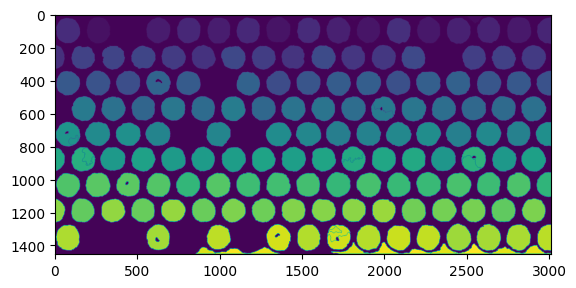

In [215]:


for target in target_list:
    data_path = f"./intermediate_result/segmentation_img_{target}.npy"
    print(data_path.split("/")[2:])
    img_dict = np.load(data_path,allow_pickle=True).item()
    for set_num in img_dict.keys():
        for f_num in img_dict[set_num].keys():
            f_num = f_num[:3]
            print(img_dict[set_num][f_num].shape)
            for idx,img in enumerate(img_dict[set_num][f_num]):
                plt.imshow(img)
                sys.exit(-1)

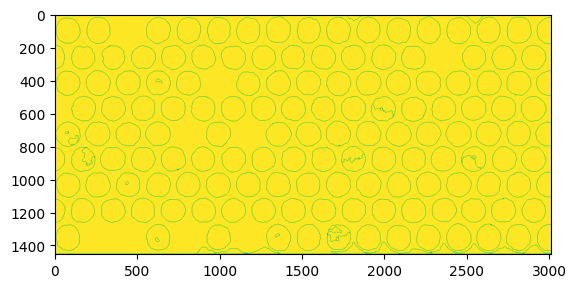

In [216]:

r = img.copy()
r[r>-1] = 1
plt.imshow(r)

In [217]:
# r_val = 870
threshold = 50
possible_section = []
for r_val in range(100,len(r)-50,15) :
    x_val, y_val = [], []
    cnt = 0
    x_val, y_val = [], []
    for idx,val in enumerate(r[r_val]):
        if val == -1:
            # print(idx,end=",")
            x_val.append(idx)
            y_val.append(r_val)
            cnt+=1
    # print("")
    if cnt > threshold and (len(possible_section) ==0 or possible_section[-1] < r_val - 100):
        possible_section.append(r_val)

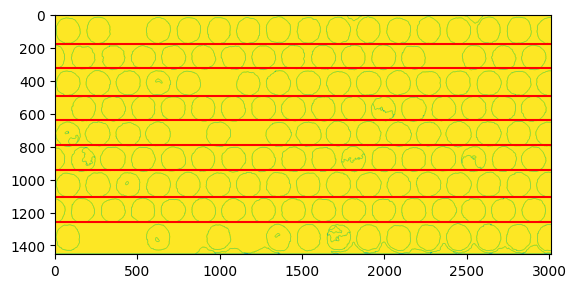

In [218]:

# plt.plot(x_val,y_val,marker='o',color='r',markersize=3)
plt.imshow(r)
# plt.axhline(r_val)
for i in possible_section:
    plt.axhline(i,color='r')

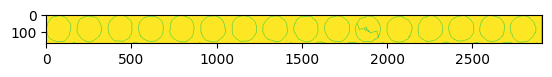

[151, 331, 511, 691, 871, 1081, 1261, 1441, 2161]


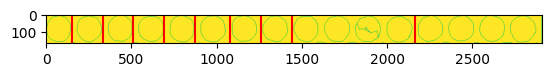

In [219]:
pad=15
for idx,split_line in enumerate(possible_section):
    start = 0
    if idx != 3 :
        continue
    if idx !=0:
        start = possible_section[idx-1]-pad
        start = 0 if start <0 else start
    subset_r = r[start:split_line+pad,:][14:,100:]
    subset_img = img[start:split_line+pad,:][14:,100:]
    plt.imshow(subset_r)
    plt.pause(0.01)
    
    threshold=1
    possible_section_subset = []
    search_pad = 0 # 5
    for col in range(1,subset_r.shape[1]-1,30):
        x_val, y_val = [], []
        cnt = 0
        x_val, y_val = [], []
        # print(subset_r[:,col].shape)
        for idx,val in enumerate(subset_r[:,col]):
            if idx < search_pad or idx > len(subset_r[:,col])-search_pad:
                continue
            if val == -1:
                if idx != 0 and subset_r[:,col][idx-1] != -1:
                    cnt+=1
        #             print(idx,end=",")
        # print(f" ({col})")
        if cnt <= threshold :
            if len(possible_section_subset) == 0 or possible_section_subset[-1] < col-120:
                possible_section_subset.append(col)


    print(possible_section_subset)
    plt.imshow(subset_r)
    # plt.axhline(r_val)
    for i in possible_section_subset:
        plt.axvline(i,color='r')

166


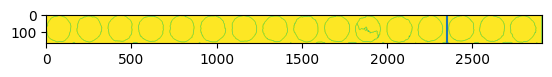

In [221]:
plt.imshow(subset_r)
print(len(subset_r))
plt.axvline(2350)

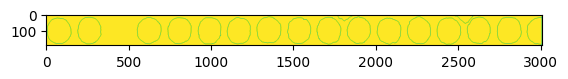

In [233]:

pad=10
plt.imshow(r[:possible_section[0]+pad,:])
subset_r = r[:possible_section[0]+pad,:]
subset_img = img[:possible_section[0]+pad,:]

[180, 360, 510, 720, 900, 1080, 1260, 1440, 1620, 1800, 1980, 2160, 2340, 2520, 2700, 2910]


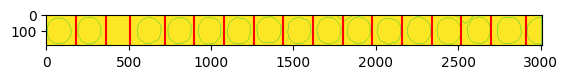

In [234]:
threshold=2
possible_section_subset = []
for col in range(0,subset_r.shape[1],30):
    x_val, y_val = [], []
    cnt = 0
    x_val, y_val = [], []
    # print(subset_r[:,col].shape)
    for idx,val in enumerate(subset_r[:,col]):
        if val == -1:
            cnt+=1
    # print("")
    if cnt <= threshold :
        if len(possible_section_subset) == 0 or possible_section_subset[-1] < col-120:
            possible_section_subset.append(col)

        
print(possible_section_subset)
plt.imshow(subset_r)
# plt.axhline(r_val)
for i in possible_section_subset:
    plt.axvline(i,color='r')

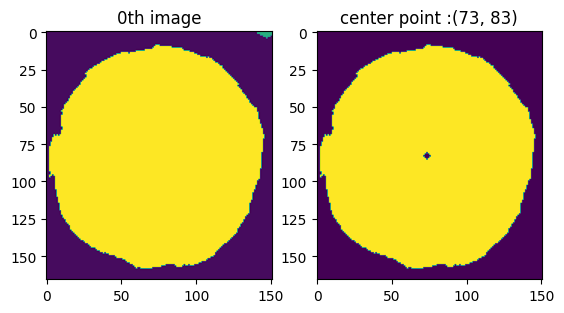

In [235]:
for idx in range(len(possible_section_subset)):
    start, end = 0, possible_section_subset[idx]
    if idx != 0:
        start = possible_section_subset[idx-1]
    img = subset_img[:,start:end]
    img_r = subset_r[:,start:end]
    plt.subplot(121)
    plt.title(f"{idx}th image")
    plt.imshow(img)
    info = find_center(img,False)
    (cX,cY), marker = info
    plt.subplot(122)
    plt.title(f"center point :{cX,cY}")
    plt.imshow(marker)
    plt.pause(0.01)
    break
    # print(info)

# Visualize showing Diameter of it

center : 73,83
angle :  30
x length, y length : 124 71
2*radius :  142.88806808127822


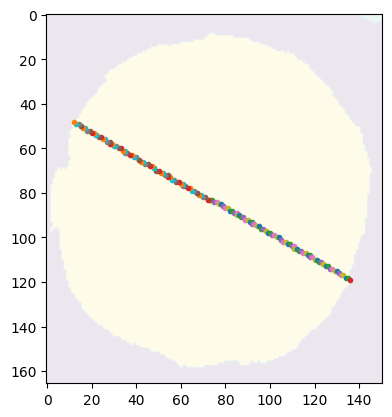

In [ ]:
i = 0
j = 0
find_right = False
find_left = False
angle=30
print(f"center : {cX},{cY}")
print(f"angle : ",angle)
debug = True
while not find_right or not find_left:
    if find_right is False:
        i+= 1
        x1 = int(np.cos(np.pi / 180 * angle)*i)
        y1 = int(np.sin(np.pi / 180 * angle)*i)
        
        if debug is True:
            plt.scatter(cX+x1,cY+y1,marker='.')
        if img[cY+y1][cX+x1] <= 1 :
            if value == 1:
                i-=1
                x1 = int(np.cos(np.pi / 180 * angle)*i)
                y1 = int(np.sin(np.pi / 180 * angle)*i)
            #print("right : ",y1)
            find_right = True
    if find_left is False:
        j-=1
        x2 = int(np.cos(np.pi / 180 * angle)*j)
        y2 = int(np.sin(np.pi / 180 * angle)*j)
        if debug is True:
            plt.scatter(cX+x2,cY+y2,marker='.')
        value = img[cY+y2][cX+x2]
        if value <= 1  :
            if value == 1:
                j+=1
                x2 = int(np.cos(np.pi / 180 * angle)*j)
                y2 = int(np.sin(np.pi / 180 * angle)*j)
            #print(markers[cX+x2][cY+y2],"left : ",y2)    
            find_left = True
#print(i-j-1)
# print(x1-x2,y1-y2)
x = x1-x2
y = y1-y2
print("x length, y length :",x,y)
print("2*radius : ",np.sqrt((x)**2 +(y)**2))
if debug is True:
    plt.imshow(img,alpha=0.1)

# To diagnose boundary edge

205
0,32,189,
3


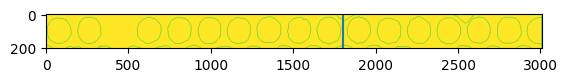

In [9]:
index=1800
cnt = 0
print(len(subset_r[:,index]))
for idx,val in enumerate(subset_r[:,index]):
    if val == -1:
        cnt+=1
        print(idx,end=",")
print("")
print(cnt)

plt.imshow(subset_r)
plt.axvline(index)

In [12]:
for index in range(1800-5,1800+5):
    # print(len(subset_r[:,index]))
    for idx,val in enumerate(subset_r[:,index]):
        if val == -1:
            cnt+=1
            # print(idx,end=",")
    print("")
    print(index,cnt)

0,28,190,
1795 6
0,29,189,
1796 9
0,29,189,
1797 12
0,30,189,
1798 15
0,31,189,
1799 18
0,32,189,
1800 21
0,33,34,189,
1801 25
0,35,189,
1802 28
0,36,189,
1803 31
0,37,189,
1804 34


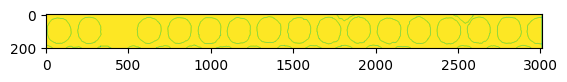

In [10]:
test_r = subset_r.copy()
plt.imshow(test_r)


In [11]:
for col in range(len(test_r[0])):
    print(row)
    hist = []
    for row in [1,len(test_r)-1]:
        if test_r[row][col] == -1:
            hist.append([row,col])
        

SyntaxError: invalid syntax (1765194828.py, line 5)